# Computation

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

df = pd.read_csv("daily_rainfall_jalgaon_chalisgaon_talegaon_2022.csv")

def compute_runoff(rain):
    if(rain < 0):
        return None
    if(rain < 25):
        return 0.2*rain
    if(rain < 50):
        return 0.3*rain
    if(rain < 75):
        return 0.4*rain
    if(rain < 100):
        return 0.5*rain
    return 0.7*rain

def compute_data(prev_sm, rain, soil_quality):
    gamma = 0.2 if(soil_quality == "deep") else 0.4
    C = 100 if(soil_quality == "deep") else 42
    runoff = compute_runoff(rain)

    infiltration = rain + prev_sm - runoff
    crop_uptake = min(infiltration, 4)
    effective_infil = infiltration - crop_uptake
    excess = max(effective_infil - C, 0)
    sm_plus_gw = effective_infil - excess

    sm = sm_plus_gw/(1+gamma)
    gw = sm_plus_gw - sm

    return rain, runoff + excess, crop_uptake, sm, gw

# Output

In [40]:
deep_file = open("output/deep_sm.csv", "w")
shallow_file = open("output/shallow_sm.csv", "w")
deep_file.write("date,rain_mm,total_runoff_mm,crop_water_uptake_mm,soil_moisture_mm,percolation_to_groundwater_mm\n")
shallow_file.write("date,rain_mm,total_runoff_mm,crop_water_uptake_mm,soil_moisture_mm,percolation_to_groundwater_mm\n")

# assuming initial soil moisture is 0
deep_prev_sm = 0
shallow_prev_sm = 0

for i in range(len(df["rain_mm"])):
    deep_data = compute_data(deep_prev_sm, df["rain_mm"][i], "deep")
    shallow_data = compute_data(shallow_prev_sm, df["rain_mm"][i], "shallow")
    
    deep_file.write(df["date"][i])
    for j in range(len(deep_data)):
        deep_file.write("," + str(deep_data[j]))
    deep_file.write("\n")
    
    shallow_file.write(df["date"][i])
    for j in range(len(shallow_data)):
        shallow_file.write("," + str(shallow_data[j]))
    shallow_file.write("\n")

    deep_prev_sm = deep_data[3]
    shallow_prev_sm = shallow_data[3]

deep_file.close()
shallow_file.close()

# Validation

In [41]:
deep_df = pd.read_csv("output/deep_sm.csv")
shallow_df = pd.read_csv("output/shallow_sm.csv")

deep_data_valid = True
shallow_data_valid = True

deep_prev_sm = 0
for i in range(np.shape(deep_df)[0]):
    temp = deep_df["soil_moisture_mm"][i] - deep_prev_sm + deep_df["total_runoff_mm"][i] + deep_df["crop_water_uptake_mm"][i] + deep_df["percolation_to_groundwater_mm"][i]
    deep_prev_sm = deep_df["soil_moisture_mm"][i]
    if(temp - deep_df["rain_mm"][i] > 0.00000001):
        deep_data_valid = False

print("validity of deep data : " + str(deep_data_valid))

shallow_prev_sm = 0
for i in range(np.shape(shallow_df)[0]):
    temp = shallow_df["soil_moisture_mm"][i] - shallow_prev_sm + shallow_df["total_runoff_mm"][i] + shallow_df["crop_water_uptake_mm"][i] + shallow_df["percolation_to_groundwater_mm"][i]
    shallow_prev_sm = shallow_df["soil_moisture_mm"][i]
    if(temp - shallow_df["rain_mm"][i] > 0.000001):
        shallow_data_valid = False

print("validity of shallow data : " + str(shallow_data_valid))

validity of deep data : True
validity of shallow data : True


# Plotting Data

<Axes: xlabel='percolation_to_groundwater_mm', ylabel='Count'>

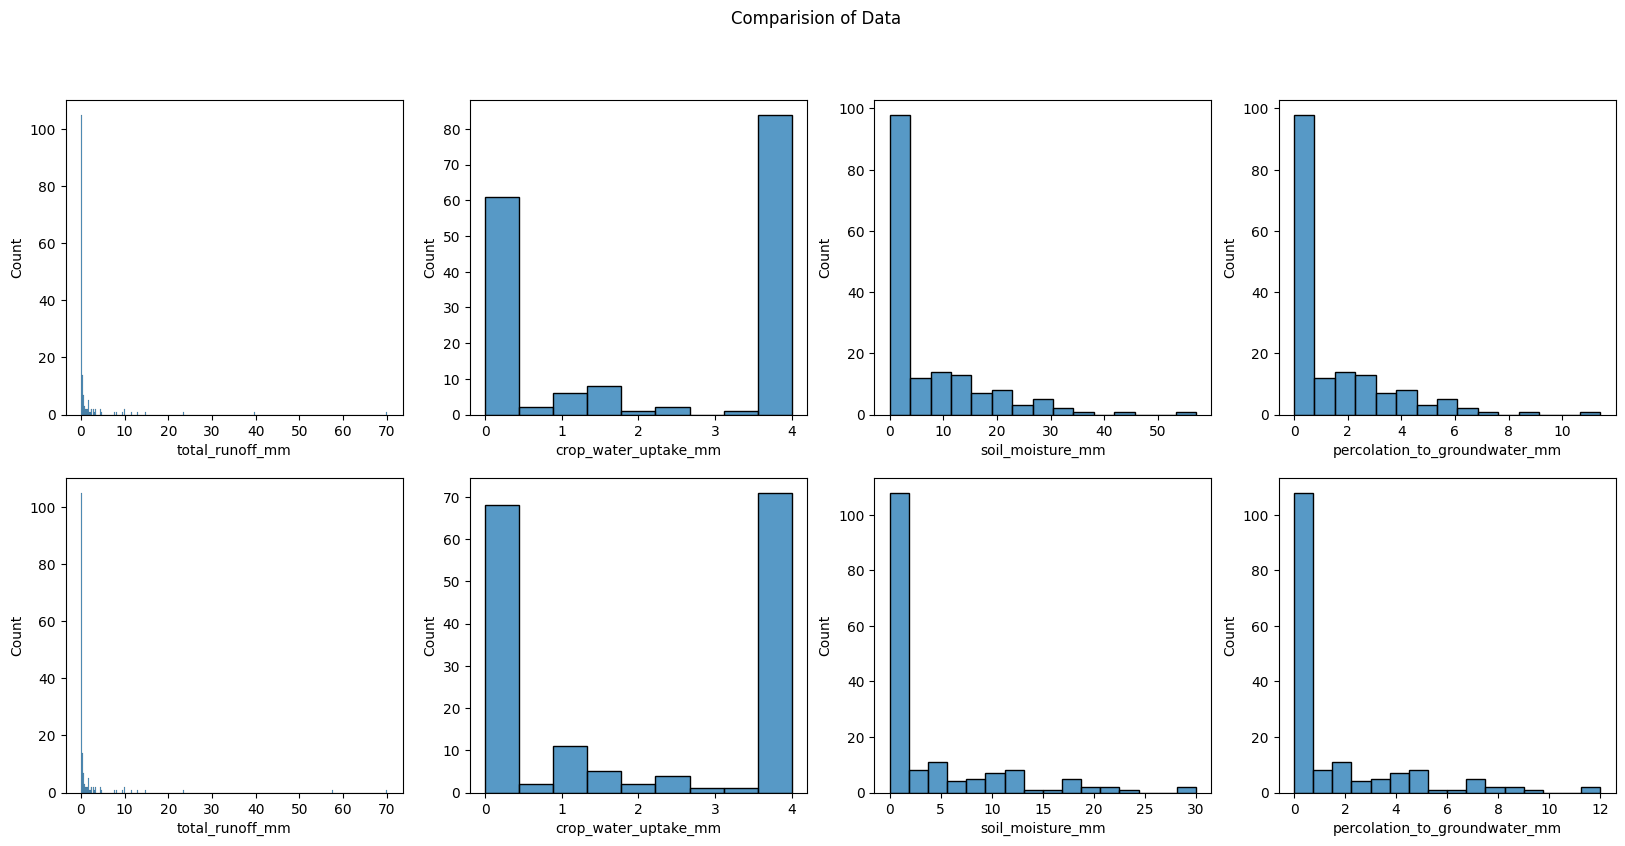

In [42]:
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,9))
fig.suptitle("Comparision of Data")

# deep in the first row and shallow in the second row
sb.histplot(data=deep_df["total_runoff_mm"], ax=axes[0,0])
sb.histplot(data=shallow_df["total_runoff_mm"], ax=axes[1,0])
sb.histplot(data=deep_df["crop_water_uptake_mm"], ax=axes[0,1])
sb.histplot(data=shallow_df["crop_water_uptake_mm"], ax=axes[1,1])
sb.histplot(data=deep_df["soil_moisture_mm"], ax=axes[0,2])
sb.histplot(data=shallow_df["soil_moisture_mm"], ax=axes[1,2])
sb.histplot(data=deep_df["percolation_to_groundwater_mm"], ax=axes[0,3])
sb.histplot(data=shallow_df["percolation_to_groundwater_mm"], ax=axes[1,3])

# Observations

* Runoff is the same for both types of soils. Excess runoff is higher in the case of shallow soil.
* Crop water uptake seems to be greater for deep soil. This is expected as deep soil can retain more moisture for periods of less rain.
* Soil moisture seems to be higher in general for deep soil.
* Percolation to groundwater is lower for deep soil and higher for shallow soil given the same soil moisture. Therefore the percolation to groundwater for both soils are similar in this scenario. This may imply that restoration of groundwater supply is independent of nature of soil.